# Finding K2-twos: Campaign 12

### Outline

* Query [2MASS All-Sky Point Source Catalog](http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd?catalog=fp_psc&mode=html&passproj&) for stars within: 
   
   * [Campaign 11](http://keplerscience.arc.nasa.gov/images/campaign_selected/field11-final.png) RA~(275,250), Dec~(-15, -33)
   * [Campaign 12](http://keplerscience.arc.nasa.gov/images/campaign_selected/field12-final.png) RA~(343,362), Dec~(3,-14)
   * [Campaign 13](http://keplerscience.arc.nasa.gov/images/campaign_selected/field13-final.png) RA~(63,82), Dec~(12,29)

* If limited to J mags $11<J<8$, this gives us ~7600 sources for Campaign 8. I'm advocating for 2MASS here because the bright limit for SDSS is too faint ("bright limit is r~14.5" according to my SDSS friend) compared to what we want for ground based spectroscopy.

* Use approximate relations [the first Ecliptic Plane Input Catalog](https://archive.stsci.edu/k2/KSCI-19082-001.pdf) (based on the Appendix of [Howell et al. 2012](http://adsabs.harvard.edu/abs/2012ApJ...746..123H)) to convert 2MASS J, K to approximate Kepler magnitudes. 

Given $x=J-K$,

$$ K_p = 0.42443603 + 3.7937617 x - 2.3267277 x^2 + 1.4602553 x^3 + K $$

for all stars with $J-H > 0.75$ and $H-K > 0.1$ (approximate color cut for giants), and

$$ K_p = 0.314377 + 3.85667 x + 3.176111 x^2 - 25.3126 x^3 + 40.7221 x^4 - 19.2112 x^5 + K $$

for all remaining stars. 

* Use the [K2FOV tool](http://keplerscience.arc.nasa.gov/K2/ToolsK2FOV.shtml) to narrow that list down to just the stars that will fall on silicon in Campaign 11-13. 

* Use this list produced in (3) to search for pairs of bright stars with separations $<N$ arcsec

* Sort by $K_p$, take top 999 sources.

### Import 2MASS PSC objects near the campaign FOV

In [1]:
%matplotlib inline
from astropy.io import ascii
from astropy.table import Table, Column
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
import matplotlib.pyplot as plt
from os import rename

# 2MASS PSC Query: 
# ra >250 and ra <275 and dec >-33 and dec <-15 and j_m >0 and j_m <12
path = 'IPACtables/IpacTableFromSource_C12.tbl'
outputdir = 'campaign12/'
campaign_number = 12
tbl = ascii.read(path)

### Calculate approximate Kepler mag $K_p$, make cuts

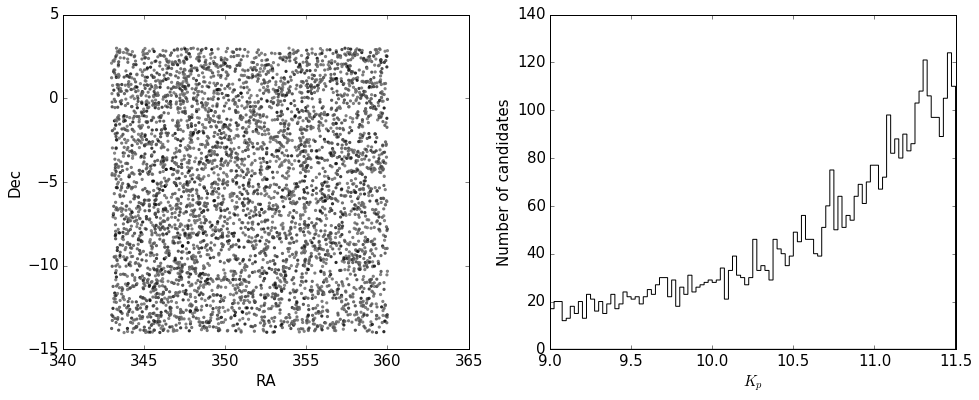

In [2]:
def JHK_to_Kp_giants(J, K):
    '''
    Convert 2MASS J, K to Kepler mag Kp for giant stars
    with J−H>0.75 and H−K>0.1
    '''
    x = J - K
    return 0.42443603 + 3.7937617*x - 2.3267277*x**2 + 1.4602553*x**3 + K

def JHK_to_Kp_other(J, K):
    '''
    Convert 2MASS J, K to Kepler mag Kp for non-giant 
    stars with J−H<0.75 and H−K<0.1
    '''
    x = J - K
    return 0.314377 + 3.85667*x + 3.176111*x**2 - 25.3126*x**3 + \
           40.7221*x**4 - 19.2112*x**5 + K

Kp = np.zeros(len(tbl['j_m']))

J = tbl['j_m']
H = tbl['h_m']
K = tbl['k_m']

giant_stars = (J-H > 0.75)*(H-K>0.1) * (-0.2 < J-K)*(J-K < 1.2)
other_stars = ~giant_stars * (-0.2 < J-K)*(J-K < 1.0) # logical not giants
Kp[giant_stars] = JHK_to_Kp_giants(J[giant_stars], K[giant_stars])
Kp[other_stars] = JHK_to_Kp_other(J[other_stars], K[other_stars])

# Impose a Kp cut for those useful to us (and reasonable)
#useful = (9 < Kp)*(Kp < 12) * other_stars
useful = (9 < Kp)*(Kp < 11.5) * other_stars
useful_tbl = tbl[useful]
useful_tbl['Kp'] = Column(Kp[useful])

def plotfield(tbl):
    # Make colormap correspond to Kepler mag
    colorscale = 1. / tbl['Kp']
    colorscale = 2*colorscale/colorscale.max() - 1
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    cm = plt.cm.binary
    ax[0].scatter(tbl['ra'], tbl['dec'], marker='.', 
                  alpha=0.75, color=cm(colorscale))
    ax[0].set_xlabel('RA')
    ax[0].set_ylabel('Dec')

    ax[1].hist(tbl['Kp'], 100, histtype='stepfilled',
               color='w')
    ax[1].set_ylabel('Number of candidates')
    ax[1].set_xlabel('$K_p$')
    plt.show()
    
plotfield(useful_tbl)

In [3]:
# Write out current table to format for K2fov:
k2fov_tbl = useful_tbl[['ra', 'dec', 'Kp', 'j_m', 'h_m', 'k_m']]
outputpath = outputdir+'k2-twos.csv'
ascii.write(k2fov_tbl, outputpath, delimiter=',', comment=False, format='no_header')

### Run the tool for K2 visibility in Campaign

In [4]:
import K2fov
K2fov.K2onSilicon(outputpath, campaign_number)
new_png_path = outputdir + 'targets_fov.png'
new_targets_path = outputdir + 'targets_siliconFlag.csv'
rename('targets_fov.png', new_png_path)
rename('targets_siliconFlag.csv', new_targets_path)

I made two files: targets_siliconFlag.csv and targets_fov.png


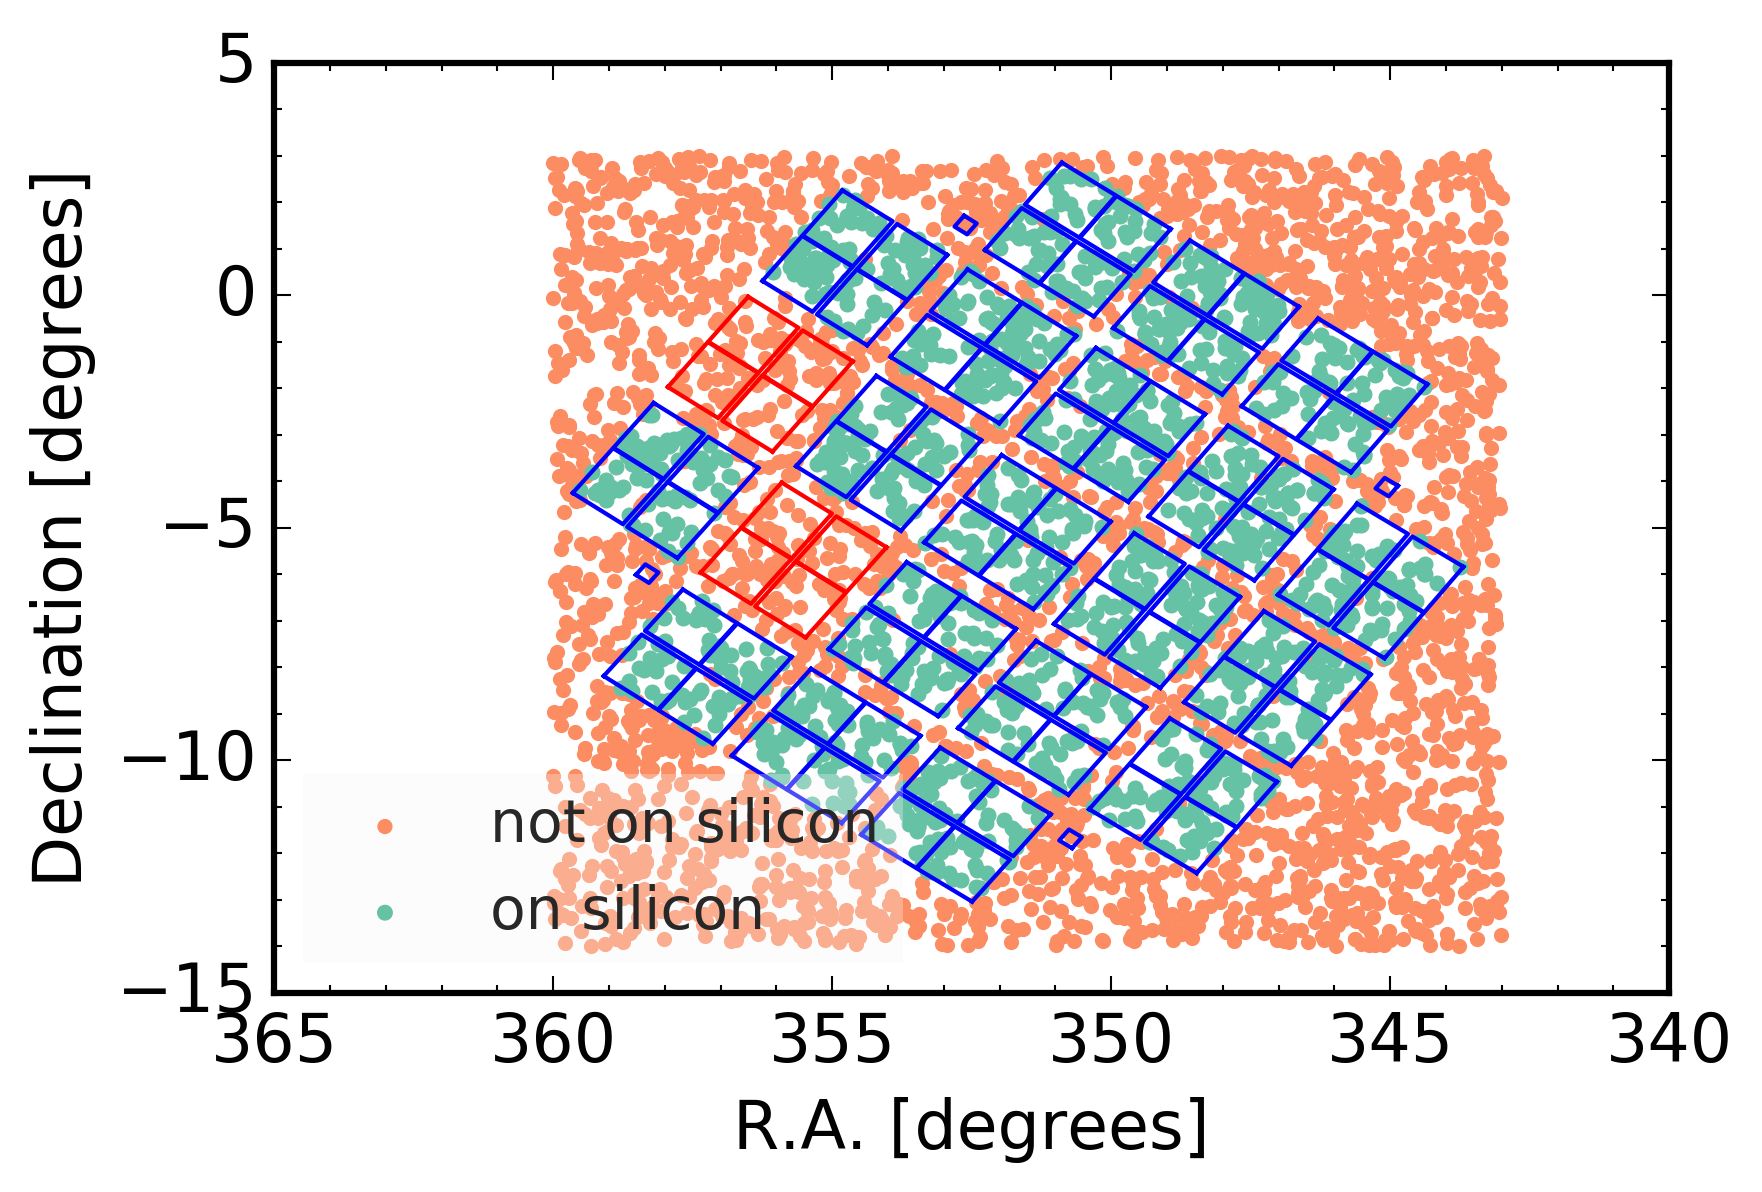

In [5]:
# Display output file
from IPython.display import Image
Image(filename=new_png_path) 

### Save list of RA, Dec, $K_p$ for available targets in `on_chip.csv`

In [6]:
# Load flagged output file, make smaller file with just the 
# targets that fall on silicon called 'on_chip.csv'
flagged_tbl = np.loadtxt(outputdir+'targets_siliconFlag.csv', delimiter=',')

import astropy.units as u
on_chip = Table(k2fov_tbl[flagged_tbl[:,3] == 2], 
                names=['ra','dec','Kp','j','h','k'])
on_chip['ra'].unit = u.degree
on_chip['dec'].unit = u.degree

ascii.write(on_chip, outputdir+'on_chip.csv')

### Show final targets for neighbor search

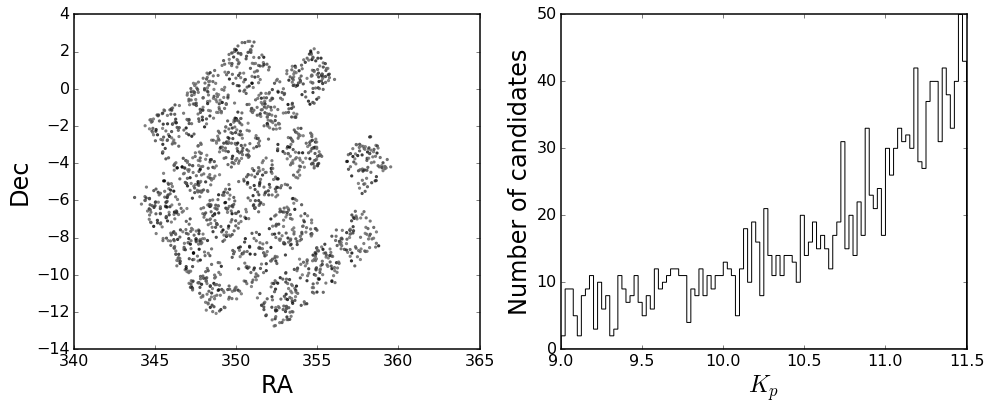

In [7]:
plotfield(on_chip)

# Now find pairs in the FOV: 

Excluding star at (355.299953,0.785575) for nearby contaminant
Excluding star at (355.293498,0.790046) for nearby contaminant
Excluding star at (355.261052,0.718632) for nearby contaminant
Excluding star at (355.25947,0.722223) for nearby contaminant
Excluding star at (355.261052,0.718632) for nearby contaminant
Excluding star at (348.793343,-7.248978) for nearby contaminant
Excluding star at (349.393005,-0.835103) for nearby contaminant
Excluding star at (349.393319,-0.833701) for nearby contaminant


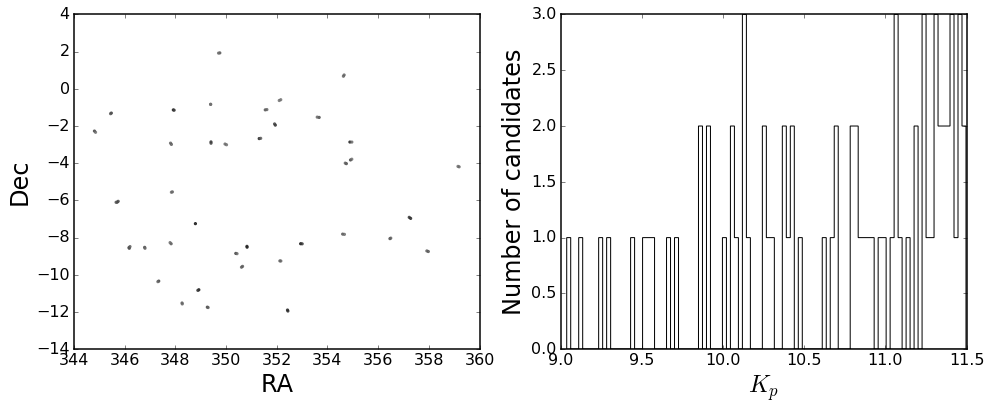

In [15]:
from astropy.coordinates import SkyCoord

############################################################
# Settings #################################################

path = outputdir+'candidates_with_neighbors.txt' # output file name
recalculate = True # Calculate or use precalculated table

# Settings for the K2-two pairs
pair_separation_limits = [2, 5] # Inner and outer angle in arcmin
pair_delta_Kp = 2. # Maximum difference in Kepler magnitude

# Precautions to avoid nearby contaminant stars
contaminant_separation_limit = 0.5 # [arcmin] toss pairs with contaminants this close

# Impose a late magnitude limit to tweak number of stars produced by final cut
late_mag_limit = 11.5

# Impose a tolerance limit on color difference between pair
J_minus_H_tol = 0.04

############################################################

if recalculate:
    on_chip = ascii.read(outputdir+'on_chip.csv')
    on_chip = on_chip[on_chip['Kp'] < late_mag_limit]
    on_chip['ra'].unit = u.degree
    on_chip['dec'].unit = u.degree

    has_neighbor = np.zeros(len(on_chip['ra'])).astype(bool)
    N_neighbors = np.zeros(len(on_chip['ra']))
    
    # Store vectorized coordinates for all stars
    allstarsonchip = SkyCoord(on_chip['ra'], on_chip['dec'])

    for i, star in enumerate(on_chip):
        ra, dec, Kp, jm, hm, km = list(star)
        
        # Calculate separation, mag difference between all stars
        candidate = SkyCoord(ra, dec, unit=(u.degree, u.degree))
        separations = candidate.separation(allstarsonchip).arcmin
        deltaKp = np.abs(on_chip['Kp'] - Kp)
        J_minus_H = np.abs((on_chip['j'] - on_chip['h']) - (jm - hm))
        good_neighbors = ((separations > pair_separation_limits[0]) & 
                          (separations < pair_separation_limits[1]) &
                          (deltaKp < pair_delta_Kp) & 
                          (J_minus_H < J_minus_H_tol))
        
        # If any stars fall within separation+mag thresholds,                    
        # check if either of the stars in the candidate pair has
        # a bright star nearby that could fall into your slit
        if np.sum(good_neighbors) > 0:
            # State Farm is there.
            N_neighbors[i] = np.sum(good_neighbors)
            
            no_contaminants = np.ones(np.sum(good_neighbors)).astype(bool)
            for j, star in enumerate(on_chip[good_neighbors]):
                ra, dec, Kp, jm, hm, km  = list(star)
                candidate_with_neighbor = SkyCoord(ra, dec, unit=(u.degree, u.degree))
                separations = candidate_with_neighbor.separation(allstarsonchip).arcmin
                any_contaminants = np.sum(separations < contaminant_separation_limit)
                
                if any_contaminants > 1:
                    # There will always be at least one "contaminant" by this
                    # definition (the target star), so trigger on >1
                    no_contaminants[j] = False
                    print("Excluding star at ({0},{1}) for nearby contaminant".format(ra,dec))
            
            # If there are no nearby contaminants, mark this star as a valid
            # candidate with a neighbor
            if no_contaminants.all():
                has_neighbor[i] = True
    
    candidates_with_neighbors = on_chip[has_neighbor]
    candidates_with_neighbors.sort('Kp')
    ascii.write(candidates_with_neighbors, path, delimiter='\t', format='no_header')
else:
    candidates_with_neighbors = ascii.read(path)
    
plotfield(candidates_with_neighbors)

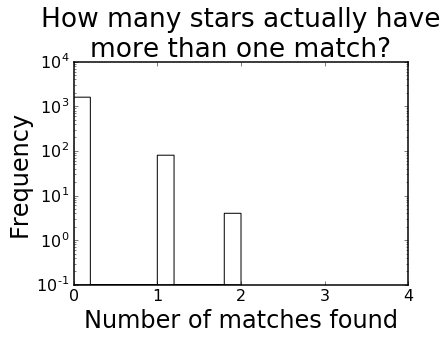

Number of stars with 0 matching comparisons: 1596
Number of stars with 1 matching comparisons: 80
Number of stars with 2 matching comparisons: 4
Number of stars with 3 matching comparisons: 0
Number of stars with 4 matching comparisons: 0


In [16]:
fig, ax = plt.subplots()
ax.hist(N_neighbors, histtype='stepfilled', log=True, 
        color='w')
ax.set_xticks(range(5))
ax.set_xlabel('Number of matches found')
ax.set_ylabel('Frequency')
ax.set_title('How many stars actually have\nmore than one match?')
plt.show()

for i in range(5):
    print("Number of stars with {0} matching comparisons: {1}".format(i, 
          list(N_neighbors).count(i)))

In [17]:
print 'Total targets:', len(candidates_with_neighbors)

Total targets: 77


In [11]:
# Match up EPIC list with my list, fill in missing rows from EPIC list with my rows
# http://archive.stsci.edu/k2/epic/search.php
EPIC_list_path = outputdir+'EPIC_list.txt'
EPIC_list = open(EPIC_list_path, 'r').read().split('\n\n')
candidate_array = candidates_with_neighbors.as_array()
final_list = []
cadence = '30'
for i, line in enumerate(EPIC_list):
    if 'no rows' not in line and len(line) > 0:
        final_list.append(line+'\t'+cadence)
    elif len(line) > 0:
        my_row = list(candidate_array[i])
        my_row.append(cadence)
        final_list.append('\t'.join(map(str, my_row)))
        
final_output_path = '{}campaign_{}_EPIC_list.txt'.format(outputdir, campaign_number)
with open(final_output_path, 'w') as f:
    f.write('\n'.join(final_list))

IOError: [Errno 2] No such file or directory: 'campaign12/EPIC_list.txt'